In [98]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.cm as cm
from src.data import data_prep
from src.models import mlp_model, cnn_model, evaluate_model
from src.viz import get_saliency_map
from src.viz import plot_saliency_map, plot_loss_accuracy


In [66]:
X_train_mlp, X_test_mlp, X_train_cnn, X_test_cnn, y_train, y_test = data_prep(nivel_ruido=0.0)

#Conversão das labels
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

#Carregamento dos modelos
model_cnn = load_model('best_cnn_model.keras')
model_mlp = load_model('best_mlp_model.keras')



In [67]:
#Avaliação dos modelos com diferentes níveis de ruído

niveis_ruido = [0.0, 0.1, 0.3, 0.5]

resultados_mlp = {}
for nivel in niveis_ruido:

    _, X_test_mlp_noisy, _, _, _, _ = data_prep(nivel_ruido=nivel)
    loss, acc = model_mlp.evaluate(X_test_mlp_noisy, y_test, verbose=0)
    resultados_mlp[nivel] = {'loss': loss, 'accuracy': acc}
    print(f"MLP - Ruído {nivel}: Acurácia = {acc:.4f}, Perda = {loss:.4f}")

resultados_cnn = {}
for nivel in niveis_ruido:

    X_train_mlp, X_test_mlp, X_train_cnn, X_test_cnn, y_train, y_test = data_prep(nivel_ruido=nivel)

    #Conversão das labels
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    y_test = keras.utils.to_categorical(y_test, num_classes=10)

    loss, acc = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
    resultados_cnn[nivel] = {'loss': loss, 'accuracy': acc}
    print(f"Ruído {nivel}: Acurácia = {acc:.4f}, Perda = {loss:.4f}")

MLP - Ruído 0.0: Acurácia = 0.9802, Perda = 0.0663
MLP - Ruído 0.1: Acurácia = 0.9684, Perda = 0.1034
MLP - Ruído 0.3: Acurácia = 0.7044, Perda = 0.9249
MLP - Ruído 0.5: Acurácia = 0.4939, Perda = 2.2017
Ruído 0.0: Acurácia = 0.9915, Perda = 0.0259
Ruído 0.1: Acurácia = 0.9907, Perda = 0.0271
Ruído 0.3: Acurácia = 0.9744, Perda = 0.0851
Ruído 0.5: Acurácia = 0.7774, Perda = 0.6320


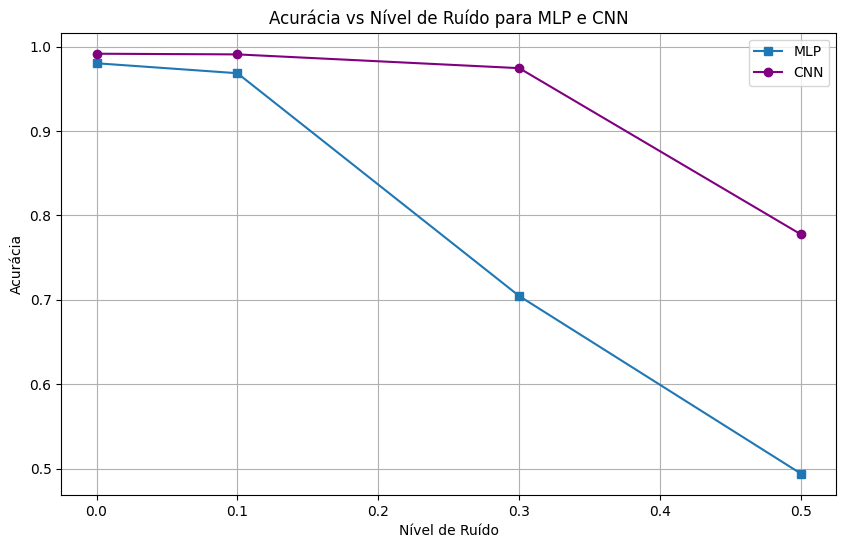

In [68]:
#Grafico de robustez

fig, ax = plt.subplots(figsize=(10, 6))
niveis = [0.0, 0.1, 0.3, 0.5] # Use a list for iteration
ax.plot(niveis, [resultados_mlp[n]['accuracy'] for n in niveis], label='MLP', marker='s')
ax.plot(niveis, [resultados_cnn[n]['accuracy'] for n in niveis], label='CNN', marker='o', color = 'purple')

ax.set_xlabel('Nível de Ruído')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia vs Nível de Ruído para MLP e CNN')
ax.legend()
ax.grid(True)
plt.show()

#Exportar figura
fig.savefig('figures/robustez_modelos.png')

In [93]:
import numpy as np
from tensorflow import keras

ruido_forte = 0.5
NUM_CLASSES = 10

# 1. Carregamento dos Modelos Treinados
# Note: Use o nome correto do arquivo que você salvou.
model_mlp = keras.models.load_model('best_mlp_model.keras')
model_cnn = keras.models.load_model('best_cnn_model.keras')

_, X_test_mlp_noisy, _, X_test_cnn_noisy, _, y_test_inteiro = data_prep(nivel_ruido=ruido_forte)

y_pred_mlp_ohe = model_mlp.predict(X_test_mlp_noisy)
y_pred_mlp = np.argmax(y_pred_mlp_ohe, axis=1)

y_pred_cnn_ohe = model_cnn.predict(X_test_cnn_noisy)
y_pred_cnn = np.argmax(y_pred_cnn_ohe, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


--- Matriz de Confusão (CNN) ---
[[835   0  53  18  12  12  10   0  14  26]
 [  0 443  88  26  86  12   5   0 471   4]
 [  0   1 954  42   4   2   1   1  24   3]
 [  0   0  11 966   0  13   0   0  13   7]
 [  0   1  11   9 827   3   1   1  70  59]
 [  2   0   1  46   0 805   6   0  20  12]
 [  5   1  17  19  48  35 761   0  64   8]
 [  3   6 174 193  20   7   0 488  66  71]
 [  1   0  13  44   3   9   0   0 900   4]
 [  1   3  14  45  51  20   1   0  95 779]]


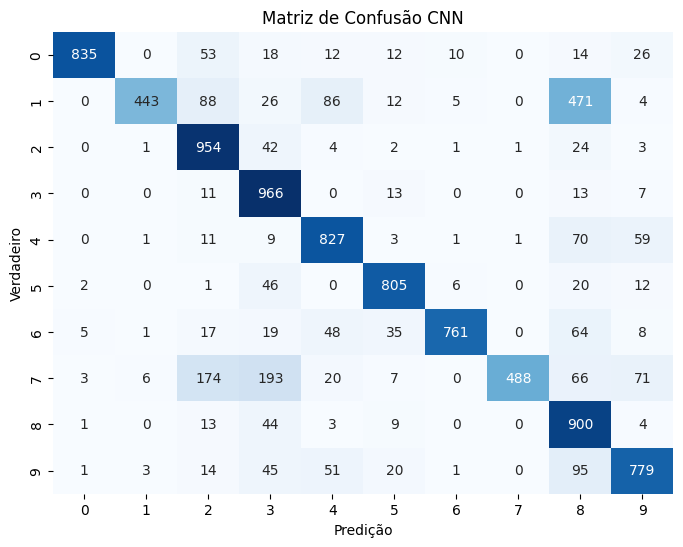

In [88]:
print("--- Matriz de Confusão (CNN) ---")
cm_cnn = confusion_matrix(y_test_inteiro, y_pred_cnn)
print(cm_cnn)

matriz_cnn = plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão CNN')
plt.show()

matriz_cnn.savefig('figures/matriz_confusao_cnn.png')


--- Matriz de Confusão (MLP) ---
[[869   0  57   3   0  23  13   1  14   0]
 [  0  18 438 168   0  47  35   0 429   0]
 [  2   0 937  32   0   6   8   3  44   0]
 [  5   0  98 738   0 112   3   1  53   0]
 [ 16   1  87  40  36  58 222   6 464  52]
 [ 10   0  56  48   0 688  24   1  65   0]
 [  7   0  92   8   0  51 694   0 106   0]
 [ 41   0 354 241   0  78  10 214  88   2]
 [  6   0 178  59   0  38  13   0 680   0]
 [ 38   0  75 161   0 104  43  11 498  79]]


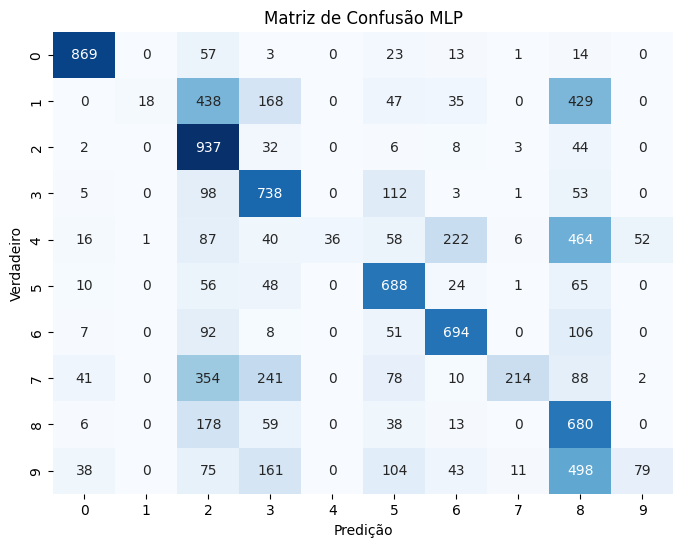

In [90]:
print("--- Matriz de Confusão (MLP) ---")
cm_mlp = confusion_matrix(y_test_inteiro, y_pred_mlp)
print(cm_mlp)

matriz_mlp = plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão MLP')
plt.show()

matriz_mlp.savefig('figures/matriz_confusao_mlp.png')

In [101]:
# Relatório de classificação para MLP
print("\n--- Relatório de Classificação (MLP) ---")
print(classification_report(y_test_inteiro, y_pred_mlp, digits=4))

# Relatório de classificação para CNN
print("\n--- Relatório de Classificação (CNN) ---")
print(classification_report(y_test_inteiro, y_pred_cnn, digits=4))


--- Relatório de Classificação (MLP) ---
              precision    recall  f1-score   support

           0     0.8843    0.8816    0.8830       980
           1     1.0000    0.0185    0.0363      1135
           2     0.3801    0.9012    0.5346      1032
           3     0.5017    0.7218    0.5920      1010
           4     1.0000    0.0356    0.0688       982
           5     0.5606    0.7724    0.6497       892
           6     0.6333    0.7338    0.6799       958
           7     0.9103    0.1975    0.3245      1028
           8     0.2878    0.7002    0.4079       974
           9     0.5926    0.0793    0.1399      1009

    accuracy                         0.4936     10000
   macro avg     0.6751    0.5042    0.4317     10000
weighted avg     0.6803    0.4936    0.4227     10000


--- Relatório de Classificação (CNN) ---
              precision    recall  f1-score   support

           0     0.9755    0.8531    0.9102       980
           1     0.9607    0.4088    0.5735     